In [1]:
import pandas as pd
import numpy as np
import re
import pickle
from collections import Counter

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

from nltk.corpus import stopwords
import nltk
import spacy

from multiprocessing.dummy import Pool
from multiprocessing import cpu_count

import logging
import glob

In [93]:
nlp = spacy.load('en')

## Raw data cleaning

In [2]:
ted_docs = pickle.load(open('data/Ted/ted.pickle', 'rb'))

In [3]:
ted_transcripts = []
[ted_transcripts.append(doc['transcript']) for doc in ted_docs];

In [18]:
clean_titles = []
[clean_titles.append('\"'+doc['title']+'\"') for doc in ted_docs];
title_df = pd.DataFrame({'title':clean_titles})
title_df.to_csv('ted_title.csv', index=False)

In [22]:
pickle.dump(all_titles, open('all_titles.pkl', 'wb'))

In [146]:
ted_titles = []
[ted_titles.append('TEDD_'+doc['title']) for doc in ted_docs];
ted_views = []
[ted_views.append('TEDD_'+doc['viewership']) for doc in ted_docs];
ted_dates = []
[ted_dates.append('TEDD_'+doc['upload_day'].split(',')[1].strip()) for doc in ted_docs];

In [136]:
tedx_files = [path for path in glob.glob('data/Tedx/*.pickle')]
tedx_docs = []
[tedx_docs.extend(pickle.load(open(fname, 'rb'))) for fname in tedx_files];

In [147]:
tedx_transcripts = []
[tedx_transcripts.append(doc['transcript']) for doc in tedx_docs];
tedx_titles = []
[tedx_titles.append('TEDX_'+doc['title']) for doc in tedx_docs];

tedx_views = []
[tedx_views.append('TEDX_'+doc['viewership']) for doc in tedx_docs];
tedx_dates = []
[tedx_dates.append('TEDX_'+doc['upload_day'].split(',')[1].strip()) for doc in tedx_docs];

In [ ]:
upload_day 'Nov 4, 2016' 'Jul 11, 2013' date 'May 19, 2014'

In [148]:
idea_docs = pickle.load(open('data/Ted/idea_text.pickle', 'rb'))
idea_texts = []
[idea_texts.append(doc['text']) for doc in idea_docs];
idea_titles = []
[idea_titles.append('IDEA_'+doc['title']) for doc in idea_docs];

idea_views = []
[idea_views.append('IDEA_'+doc['viewership']) for doc in idea_docs];
idea_dates = []
[idea_dates.append('IDEA_'+doc['date'].split(',')[1].strip()) for doc in idea_docs];

In [8]:
all_texts = ted_transcripts + tedx_transcripts + idea_texts
all_titles = ted_titles + tedx_titles + idea_titles

## Use pool to parellel tokenizing process

In [110]:
stop_list = list(set(list(stopwords.words('english')) + list(ENGLISH_STOP_WORDS)))+["'re"]

def text_tokenizer(s):
    s=s.lower()

    reg_filters = ['\d+', '\(\w+\)', '\<.+\>', '\-\-', '\.\.\.']
    for reg_filter in reg_filters:
        s = re.sub(reg_filter, ' ', s)
    
    ## lemmatize the tokens using spaCy
    tokens = nlp(s)
    tokens = [tok.lemma_.strip() for tok in tokens]
    return [tok for tok in tokens if len(tok) > 2 and tok not in stop_list]

In [381]:
pool_size = 16
pool = Pool(pool_size)
t1 = time()
all_res = pool.map(text_tokenizer, all_texts)
t2 = time()
print(t2-t1)

706.0771141052246


In [510]:
pickle.dump(all_res, open('all_lemma.pickle', 'wb'))

In [99]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [113]:
def nmf_topics(texts, n_topics=20, n_top_words=20):
    # Use tf-idf features for NMF.
    tfidf_vectorizer = TfidfVectorizer(max_df= 0.95, min_df=5, stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(texts)

    # Fit the NMF model
    t1=time()
    nmf = NMF(n_components=n_topics, random_state=2, alpha=.1, l1_ratio=.5).fit(tfidf)
    t2=time()
    print(t2-t1)
    print("\nTopics in NMF model:")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words) 
    return tfidf, nmf

# Topic modeling

## Generate 15 topics for presentation purpuses

In [195]:
topics= ['School', 'Education', 'Social Issues', 'Environment', 'Music',
'Energy', 'Health', 'Gender', 'Urban Planning', 'Business',
'Food', 'Technology', 'Family', 'Human Mind', 'Games']

In [ ]:
all_res=pickle.load( open('all_lemma.pickle', 'rb'))

In [157]:
processed_texts = [' '.join(w_list) for w_list in all_res]
tfidf, nmf = nmf_topics(processed_texts, n_topics=17)

69.7084310054779

Topics in NMF model:
Topic #0:
know say think thing people want really time make life come good right tell day look feel talk love way
Topic #1:
yeah yes okay home know hey uh say mom lol yahoo um use hmm good haha right song alright day
Topic #2:
school kid teacher girl education year high parent teach grade program young community learn college adult boy class classroom district
Topic #3:
student teacher education classroom learn school class learning teach university college math high skill teaching educational question grade test need
Topic #4:
people country world community social change government africa state society year need percent global issue problem young political organization health
Topic #5:
water ocean planet earth animal fish specie sea year nature plant tree river space universe climate human world look forest
Topic #6:
music song play sound musician instrument musical guitar sing listen classical artist piano composer art orchestra dance concert pi

## Generate 30 topics for the final model 

In [479]:
# all texts
processed_texts = [' '.join(w_list) for w_list in all_res]
tfidf, nmf = nmf_topics(processed_texts, n_topics=30)

124.48314595222473

Topics in NMF model:
Topic #0:
say life time want make day come know feel year love think tell good thing people look start way friend
Topic #1:
yeah hey home song hmm yahoo mmm love play instrument uh lol yes mom really haha lon thank know nah
Topic #2:
school education teacher girl high college young community year program graduate grade learn public parent principal district class boy educate
Topic #3:
student teacher classroom education learn class learning teach university math college question skill teaching test science lecture grade need educational
Topic #4:
people country community world social government africa change state society need problem percent global issue political year organization united young
Topic #5:
art artist museum painting creative creativity work create paint dance image gallery project culture piece sculpture idea performance community make
Topic #6:
music song play sound musician instrument musical guitar sing listen classical piano 

In [ ]:
prob_nmf = nmf.transform(tfidf)

In [542]:
pickle.dump(prob_nmf, open('prob_nmf.pickle', 'wb'))
pickle.dump(tfidf, open('tfidf.pickle', 'wb'))
pickle.dump(nmf, open('nmf.pickle', 'wb'))

## Exploratory Analysis of topics

In [122]:
tfidf = pickle.load(open('tfidf.pickle', 'rb'))
nmf = pickle.load(open('nmf.pickle', 'rb'))

In [160]:
topics_list_all = [np.argmax(row[2:])+1 for row in prob_nmf]
Counter(topics_list_all)

Counter({1: 960,
         2: 1014,
         3: 3838,
         4: 1647,
         5: 997,
         6: 595,
         7: 1073,
         8: 998,
         9: 1081,
         10: 1466,
         11: 629,
         12: 3147,
         13: 770,
         14: 699,
         15: 456})

In [149]:
all_dates = ted_dates + tedx_dates + idea_dates

In [151]:
all_dates = [d[5:] for d in all_dates]

In [186]:
topic_df = pd.DataFrame({'date':all_dates, 'topic':topics_list_all})
topic_df['count']=1
topic_df = topic_df[topic_df['date'].isin([str(y) for y in range(2010, 2016)])]
count_by_year_topic = topic_df.groupby(['date', 'topic']).count().reset_index()
count_by_year = topic_df[['date', 'count']].groupby('date').count().reset_index()
count_by_year.columns = ['date', 'year_count']
count_by_year_topic = pd.merge(count_by_year_topic, count_by_year, on='date', how='left')
count_by_year_topic['pct'] = count_by_year_topic['count']/count_by_year_topic['year_count']*100

count_by_year_topic.drop(['count', 'year_count'], axis=1, inplace=True)
count_by_year_topic = count_by_year_topic.rename(columns={'date':'year'})

In [202]:
topic_by_year = count_by_year_topic.pivot_table(index='year',columns='topic',values='pct').round(1)
topic_by_year.columns=topics
topic_by_year

,School,Education,Social Issues,Environment,Music,Energy,Health,Gender,Urban Planning,Business,Food,Technology,Family,Human Mind,Games
year,,,,,,,,,,,,,,,
2010,4.5,3.6,19.0,9.4,4.8,3.4,5.4,3.1,5.1,8.9,2.9,20.4,3.8,2.9,2.8
2011,5.9,5.0,18.7,7.4,5.6,3.8,5.0,4.1,4.3,8.4,4.1,19.0,3.5,2.9,2.5
2012,4.4,5.2,19.3,7.4,5.5,4.1,6.3,3.7,6.2,9.1,3.4,15.8,3.8,3.7,2.2
2013,4.8,6.2,18.2,8.1,5.8,3.0,5.6,5.0,6.7,7.3,3.5,16.1,3.6,3.8,2.3
2014,5.6,5.6,21.3,8.5,5.3,2.3,5.4,5.9,5.6,6.7,3.4,13.8,4.8,3.3,2.4
2015,4.9,5.7,20.9,8.4,4.4,2.5,5.6,7.8,4.8,7.7,2.6,13.9,4.3,4.1,2.4


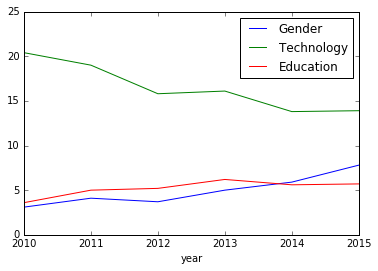

In [204]:
topic_by_year[['Gender','Technology', 'Education']].plot()

In [217]:
num_views = []
for v in all_views:
    if len(v)>5:
        num_views.append(int(v[5:].replace(',','')))
    else:
        num_views.append(0)    

In [218]:
all_views = ted_views + tedx_views + idea_views
views_df = pd.DataFrame({'view':num_views, 'topic':topics_list_all})

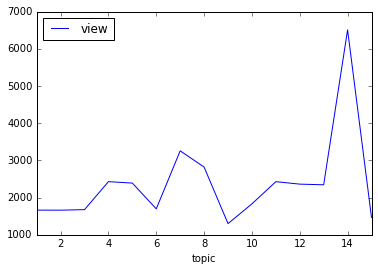

In [222]:
df = views_df.groupby('topic').median()
df.plot()

In [226]:
from annoy import AnnoyIndex
import random
f = 17
t = AnnoyIndex(f)  # Length of item vector that will be indexed
for i, row in enumerate(prob_nmf):
    v = row
    t.add_item(i, v)

t.build(10) # 10 trees

idx = t.get_nns_by_item(346, 3)
for i in idx:
    if all_titles[i][:5] == 'TEDX_':
        print(all_titles[i])

TEDX_TEDxUofM - Jameson Toole - Big Data for Tomorrow
TEDX_The Power of Community: Pete Pelberg at TEDxLMSD
TEDX_Shadows Matter: Don Salubayba at TEDxDiliman


## T-SNE Plot

In [42]:
from time import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

In [131]:
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], '+', color=plt.cm.Set1(y[i] / 10.))
                 
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [60]:
prob_nmf.shape
X_tsne.shape
pickle.dump(X_tsne, open('tsne.pickle', 'wb'))



In [83]:
ted_prob_nmf = prob_nmf[:2221,:]
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, random_state=0)
ted_tsne = tsne.fit_transform(ted_prob_nmf)

Computing t-SNE embedding


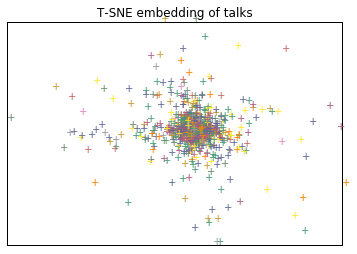

In [132]:

remove_idx = [1212,1013, 367, 574, 18, 57, 52, 1206, 409, 987, 477, 1461, 1965, 436, 818, 2167, 626, 1968, 297, 1720, 1529, 622, 760, 141 ]


X_final = np.delete(ted_tsne, remove_idx, axis=0)
y_final = np.delete(np.array(topics_list), remove_idx, axis=0)
plot_embedding(X_final, y_final, 'T-SNE embedding of talks')

plt.show()